# Predicting League of Legends Match Outcomes with Logistic Regression

In this lab you will learn how to use Logistic Regression to predict the outcome of League of Legends match using data from the first 10 minutes of the match. League of Legends is a 5v5 team based strategy game where the objective is to destroy the other team base. Our dataset has 38 features that contain data for each team and represents to top ~2.4% players in the world.

* Data Preperation
* Logistic Regression Class
* Training
* Results

## Data Preperation

In [1]:
!pip install torch
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
torch.manual_seed(0)

### About the Data

The dataset contains 39 columns, 19 for each team and 1 for the target, so we will explain the meaning of each column for a single team because they are the same but reversed for each set and the target. The data will be standardized in the dataset class.

|  Field    |      Description      |  Unit |  Type  |
|-----------|:-------------:|------:|--------:|
|  blueWins |  This is our target and tell us who won the game. 1 if the blue team won and 0 if the red team won  |  1/0  |  int  |
|  blueWardsPlaced |  Number of wards (item that gives vision) that were placed by the blue team  |  Wards  |  int  |
|  blueWardsDestroyed |  Number of wards (item that gives vision) that were placed by the red team and destroyed by the blue team  |  Wards  |  int  |
|  blueFirstBlood |  Tells us who got the first kill of the game. 1 for blue and 0 for red   |  1/0  |  int  |
|  blueKills |  Number of times the blue team killed someone in the red team  |  Kills  |  int  |
|  blueDeaths |  Number of times any player from the blue team has died either from the red team or jungle (neutral monsters)  |  Deaths  |  int  |
|  blueAssists |  Total number of assists each player in the blue team had. An assist is when a player helps another play kill and enemy in the red team  |  Assists  |  int  |
|  blueEliteMonsters |  Number of elite monsters killed by the blue team  |  Kills  |  int  |
|  blueDragons |  Number of dragons killed by the blue team  | Kills   |  int  |
|  blueHeralds |  Number of heralds killed by the blue team  |  Kills  |  int  |
|  blueTowersDestroyed |  Number of towers belonging to the red team destroyed by the blue team  |  Towers  |  int  |
|  blueTotalGold |  Total amount of gold each player in the blue team has  |  Gold  |  int  |
|  blueAvgLevel |  Avg Champion level of the blue team  |  Level  |  float  |
|  blueTotalExperience |  Total amount of experience each player in the blue team has  |  Experience  |  int  |
|  blueTotalMinionsKilled |  Total amount of minions killed by each player in the blue team  |  Kills  |  int  |
|  blueTotalJungleMinionsKilled |  Total amount of jungle monsters killed by each player in the blue team  |  Kills  |  int  |
|  blueGoldDiff |  Difference between the total gold of the red and blue team  |  Gold  |  int  |
|  blueExperienceDiff |  Difference between the total experience of the red and blue team  |  Experience  |  int  |
|  blueCSPerMin |  Number of minions or jungle monsters killed per minute  |  Kills/Min  |  float  |
|  blueGoldPerMin |  How much gold the team receives per minute  |  Gold/Min  |  float  |


### Dataset Class

In [2]:
class Dataset(Dataset):

    # Constructor
    def __init__(self, train = True):
        
        data = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/ML03210EN_Final_Assignment/LoLMatchData.csv')
        
        if (train):
            self.x = torch.tensor(data.iloc[0:7903, :].drop(['blueWins'], axis=1).values, dtype=torch.float)
            # standardizing the data
            self.x = (self.x - self.x.mean(dim=0))/self.x.std(dim=0)
            self.y = torch.tensor(data.loc[0:7903, 'blueWins'].values, dtype=torch.float).reshape((7904,1))
            self.len = self.x.shape[0]
        else:
            self.x = torch.tensor(data.iloc[7904:, :].drop(['blueWins'], axis=1).values, dtype=torch.float)
            # standardizing the data
            self.x = (self.x - self.x.mean(dim=0))/self.x.std(dim=0)
            self.y = torch.tensor(data.loc[7904:, 'blueWins'].values, dtype=torch.float).reshape((1975,1))
            self.len = self.x.shape[0]
            
    
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        x = self.x[idx]
        
        y = self.y[idx]

        return x, y

### Question 1

Using the Dataset class defined above create dataset object for training and testing data called data_train and data_test. Remember to set the train parameter to the correct value.

In [3]:
data_train = Dataset()
data_test = Dataset(train=False)

### Question 2

Using the Dataset objects created above create data loaders for each dataset called train_loader and test_loader. Set the batch_size parameter to 100.

In [4]:
train_loader = DataLoader(dataset=data_train, batch_size=100)
test_loader = DataLoader(dataset=data_test, batch_size=100)

## Logistic Regression Class

Defined below is our Logistic Regression class which will basically perform linear regression using the linear layer and then using the sigmoid activation function we can perform logistic regression.

In [5]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dimension, output_dimension):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dimension, output_dimension)
    
    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

In [6]:
model = LogisticRegression(38, 1)

## Training

### Optimizer and Loss Function

### Question 3

Before we can get to training we must define the optimizer and the loss function we will use to train our model. Please create an optimizer called optimizer that uses SGD with a learning rate of .001 and a loss function called criterion that uses BCELoss.

In [7]:
learning_rate = .001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

### Training Function

In [8]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs):
    cost_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        
        # variable to keep track of cost (total loss)
        cost = 0
        model.train()
        
        for x, y in train_loader:
            
            # clears gradients from last step
            optimizer.zero_grad()
            
            # uses model to predict target for x
            z = model(x)

            # calculates loss between prediction and ground truth
            loss = criterion(z, y)

            # calculates the derivative of the loss with respect to each parameter
            loss.backward()
            
            # updates each parameter using the optimizer algorithm and values calculated from loss.backward()
            optimizer.step()
            
            # increment cost
            cost += loss.item()
        
        # variable to keep track of correct prediction in the test set
        correct = 0
        model.eval()
        
        for x_test, y_test in test_loader:
            
            # uses model to predict target for x_test
            z = model(x_test)
            
            # rounds the output to the nearest int because our target is either 0 or 1 and the output is a probability between 0 and 1
            z = torch.round(z)
            
            # find our how many in the batch were corrent and adds it to the total for the epoch
            correct += (z == y_test).sum().item()
        
        # calculates the accuracy rate in the test data
        accuracy = correct / len(data_test)
        
        # appends the accuracy and cost to the list to keep track
        accuracy_list.append(accuracy)
        cost_list.append(cost)
    
    return accuracy_list, cost_list
        

### Question 4

Using the training function defined above, the model, criterion, and optimizer that you created before train the model for 10 epochs. Save the accuracy and cost returned to lists called accuracy_list and cost_list.

In [9]:
train(model, optimizer, criterion, train_loader, test_loader, epochs=10)

([0.6141772151898734,
  0.6648101265822784,
  0.6921518987341773,
  0.7124050632911393,
  0.719493670886076,
  0.7189873417721518,
  0.7235443037974684,
  0.7260759493670886,
  0.7245569620253165,
  0.7265822784810126],
 [54.415223479270935,
  51.12895029783249,
  48.965958416461945,
  47.490831673145294,
  46.450646817684174,
  45.695361226797104,
  45.13292184472084,
  44.70485779643059,
  44.3728004693985,
  44.11083871126175])

In [11]:
# DO THIS IN ORDER TO PRODUCE RESULTS BELOW
accuracy_list, cost_list = train(model, optimizer, criterion, train_loader, test_loader, epochs=10)

## Results

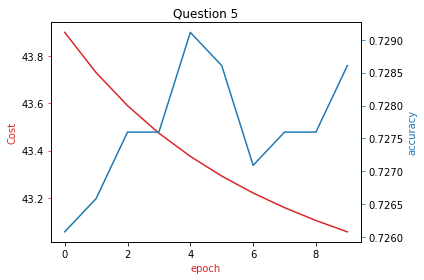

In [14]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
ax2.set_title('Question 5', color='black') 
fig.tight_layout()

<h3>Thanks for completing this lesson!</h3>

<h4>Authors: <a href="https://www.linkedin.com/in/azim-hirjani-691a07179/">Azim Hirjani</a>



<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>